# Group Proposal


**Authors:** Bryan Chang, Linda Huang, Jade Jordan, Inan Latif

**Group:** 5

## Preliminary Results


In [10]:
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(grid)
library(gridExtra)
library(taxyvr)
library(cowplot)

In [11]:
#Reading data into R, and renaming all columns to a standard format
crime_data <- 
    read.csv("crime_data_2021.csv") %>%  
    setNames(c("type",
               "year",
               "month",
               "day",
               "hour",
               "minute",
               "hundred_block",
               "neighbourhood",
               "x",
               "y"))

head(crime_data)

,type,year,month,day,hour,minute,hundred_block,neighbourhood,x,y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2021,11,21,6,33,10XX ALBERNI ST,West End,491015.9,5459166
2,Break and Enter Commercial,2021,11,26,13,58,10XX BARCLAY ST,West End,490833.8,5458887
3,Break and Enter Commercial,2021,12,14,2,2,10XX BEACH AVE,Central Business District,490252.4,5458163
4,Break and Enter Commercial,2021,7,17,5,0,10XX BEACH AVE,Central Business District,490255.4,5458159
5,Break and Enter Commercial,2021,6,15,4,0,10XX BEACH AVE,Central Business District,490258.4,5458155
6,Break and Enter Commercial,2021,7,23,6,12,10XX BEACH AVE,Central Business District,490269.9,5458141


## Cleaning Data

In [12]:
#filtering out type and minute column
crime_select <- crime_data %>% select(-year, -minute, -x, -y)

#renaming hundred_block to a more human readable format
crime_rename <- crime_select %>% 
                mutate(address = hundred_block) %>% 
                select(-hundred_block)
days_by_m <- c(0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334)
crime_newcol <- crime_rename %>%
                mutate(day = day + days_by_m[month])
clean_crime <- crime_newcol %>% filter(type == "Theft of Bicycle")
head(clean_crime)
nrow(clean_crime)

,type,month,day,hour,neighbourhood,address
,<chr>,<int>,<dbl>,<int>,<chr>,<chr>
1,Theft of Bicycle,11,305,1,West End,10XX ALBERNI ST
2,Theft of Bicycle,7,187,18,West End,10XX BEACH AVE
3,Theft of Bicycle,8,224,19,Central Business District,10XX BEACH AVE
4,Theft of Bicycle,7,201,19,Central Business District,10XX BEACH AVE
5,Theft of Bicycle,7,204,6,Central Business District,10XX BEACH AVE
6,Theft of Bicycle,9,246,2,West End,10XX BROUGHTON ST


[1] 1460

,neighbourhood,day
,<chr>,<dbl>
1,West End,305
2,West End,187
3,Central Business District,224
4,Central Business District,201
5,Central Business District,204
6,West End,246


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



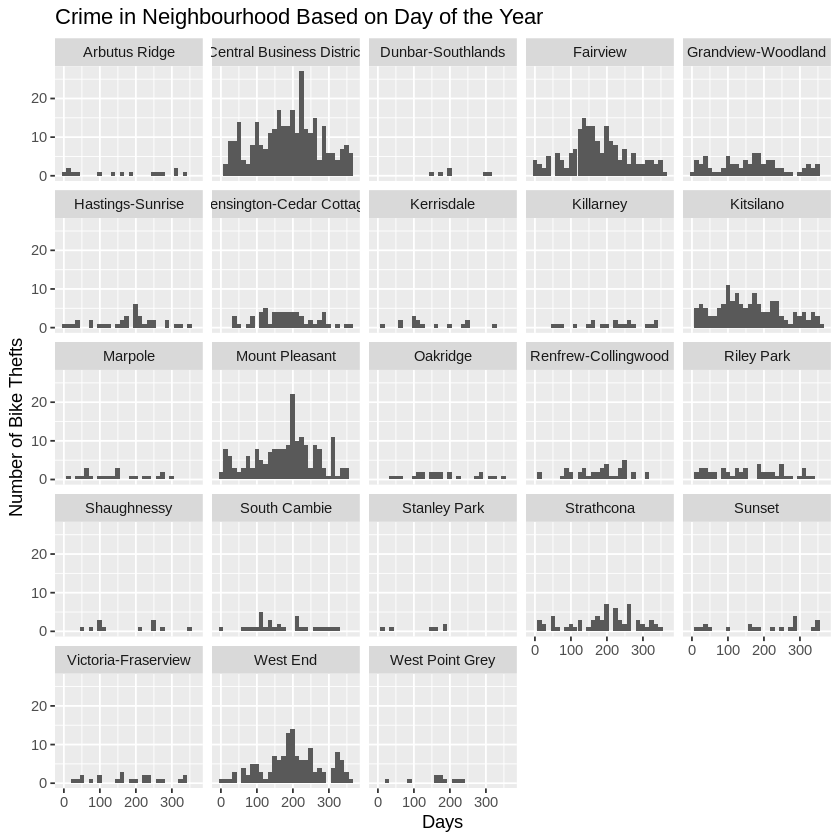

In [13]:
crime_neighbourhood_day <- clean_crime %>%
                           select(neighbourhood,day)

head(crime_neighbourhood_day)

crime_neighbourhood_day_hist <- crime_neighbourhood_day %>%
ggplot(aes(x = day)) +
geom_histogram()+
ggtitle("Crime in Neighbourhood Based on Day of the Year") +
labs(x = "Days", y = "Number of Bike Thefts") +
facet_wrap(~ neighbourhood)
crime_neighbourhood_day_hist

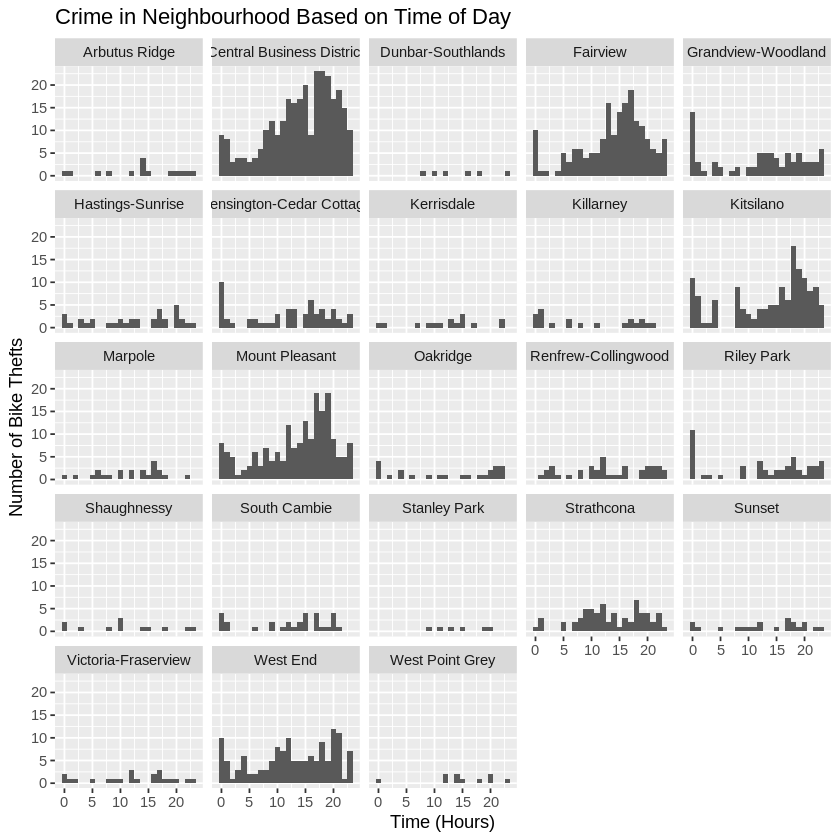

In [14]:
crime_neighbourhood_hour <- clean_crime %>%
                           select(neighbourhood,hour)

crime_neighbourhood_hour_hist <- crime_neighbourhood_hour %>%
                                 ggplot(aes(x = hour)) +
                                 geom_histogram(bins = 24)+
                                 ggtitle("Crime in Neighbourhood Based on Time of Day") +
                                 labs(x = "Time (Hours)", y = "Number of Bike Thefts") +
                                 facet_wrap(~ neighbourhood)
crime_neighbourhood_hour_hist

#### Preliminary Graphs

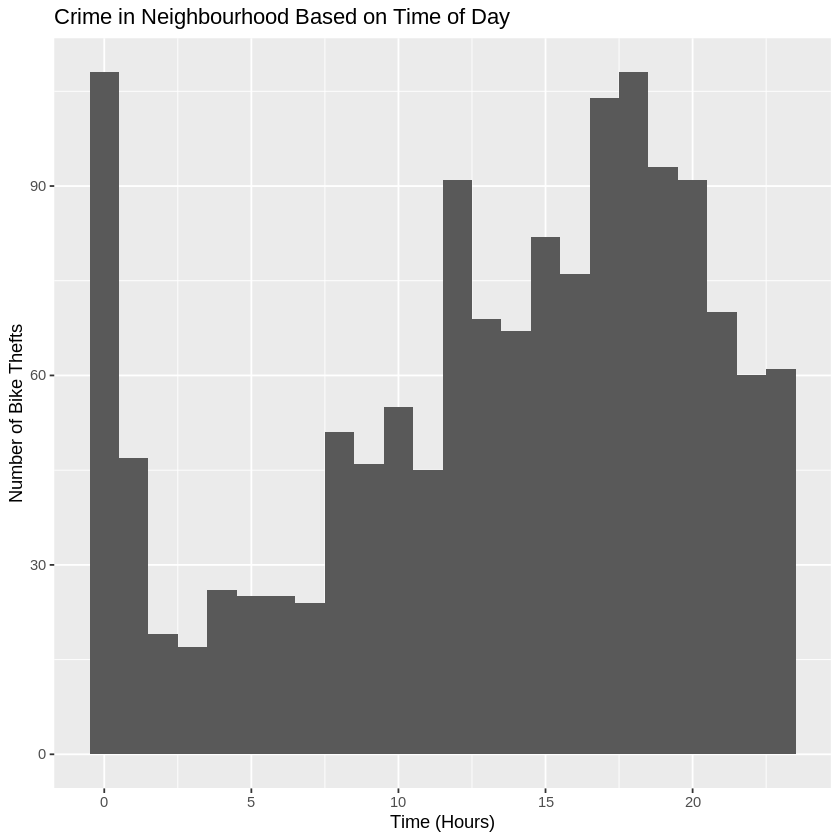

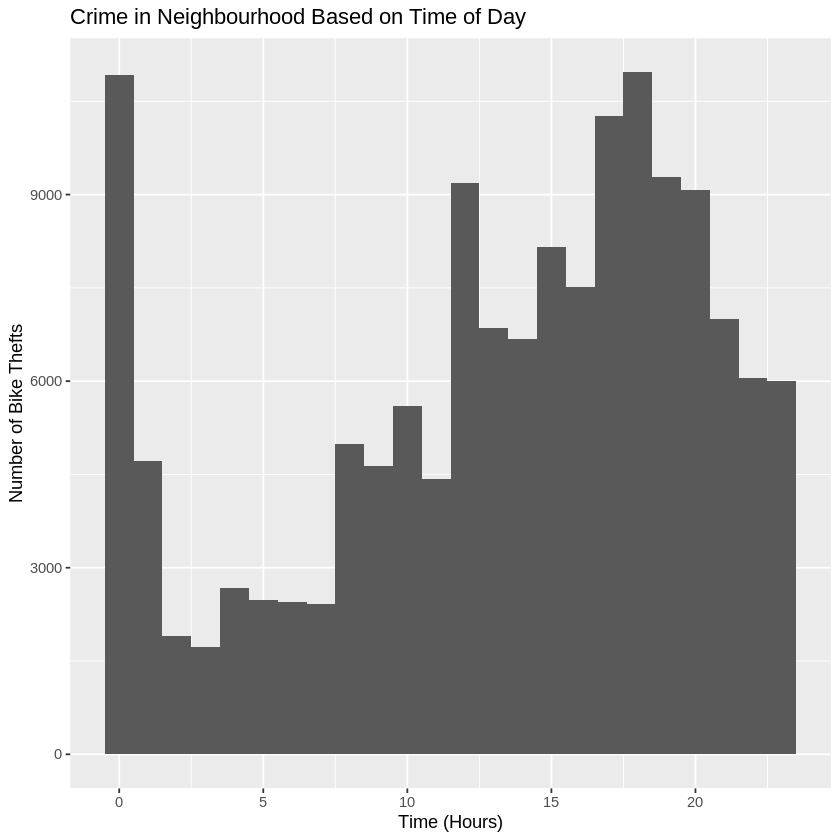

In [15]:
#generating sample
set.seed(1234) 

raw_hist_hour <- clean_crime %>%
                                 ggplot(aes(x = hour)) +
                                 geom_histogram(bins = 24)+
                                 ggtitle("Crime in Neighbourhood Based on Time of Day") +
                                 labs(x = "Time (Hours)", y = "Number of Bike Thefts")

bootstrap <- 
   clean_crime %>% 
   rep_sample_n(size = 1460, replace = TRUE, reps = 100)
bootstrap_hist_hour <- bootstrap %>%
                                 ggplot(aes(x = hour)) +
                                 geom_histogram(bins = 24)+
                                 ggtitle("Crime in Neighbourhood Based on Time of Day") +
                                 labs(x = "Time (Hours)", y = "Number of Bike Thefts")

raw_hist_hour
bootstrap_hist_hour

#### THIS IS WHERE WE LEFT OFF

In [20]:
# PICK UP HERE TAKBIR
# We are adding a new column to our data which shows us 
# whether the crime has occurred during daytime or nighttime
# create a new category "Time of Day" with TWO FACTORS ("Day", "Night")
day_night <- c(8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
clean_crime_day_night <- clean_crime %>%
                        summarise(time_of_day = ifelse(hour %in% day_night, "day", "night"))
clean_crime_new <- data.frame(clean_crime, clean_crime_day_night)
clean_crime_new <- clean_crime_new %>% select(time_of_day)
head(clean_crime_new)

,time_of_day
,<chr>
1,night
2,day
3,day
4,day
5,night
6,night


### INSERT HYPOTHESES HERE, MAYBE?
# blank line hehe

In [21]:
clean_crime_count <- clean_crime_new %>%
                        group_by(time_of_day) %>%
                        summarise(count = n())
head(clean_crime_count)
obs_test_stat <- clean_crime_count$count[1] - clean_crime_count$count[2]
obs_test_stat
obs_test_ratio <- clean_crime_count$count[1] / clean_crime_count$count[2]
obs_test_ratio

time_of_day,count
<chr>,<int>
day,887
night,573


[1] 314

[1] 1.547993

In [22]:
# Generate the bootstrap sampling distribution
set.seed(4321)
bootstrap_day <- clean_crime_new %>%
                         specify(response = time_of_day, success = c("day")) %>%
                         generate(type = "bootstrap", reps = 100) %>% 
                         calculate(stat = "count")
bootstrap_new <- bootstrap_day %>%
                        mutate(day_count = stat,
                               night_count = 1460 - stat,
                              difference = day_count - night_count,
                              ratio = day_count / night_count) %>%
                        select(-stat)
#count_crime
head(bootstrap_new)

replicate,day_count,night_count,difference,ratio
<int>,<int>,<dbl>,<dbl>,<dbl>
1,877,583,294,1.504288
2,893,567,326,1.574956
3,915,545,370,1.678899
4,915,545,370,1.678899
5,864,596,268,1.449664
6,877,583,294,1.504288


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


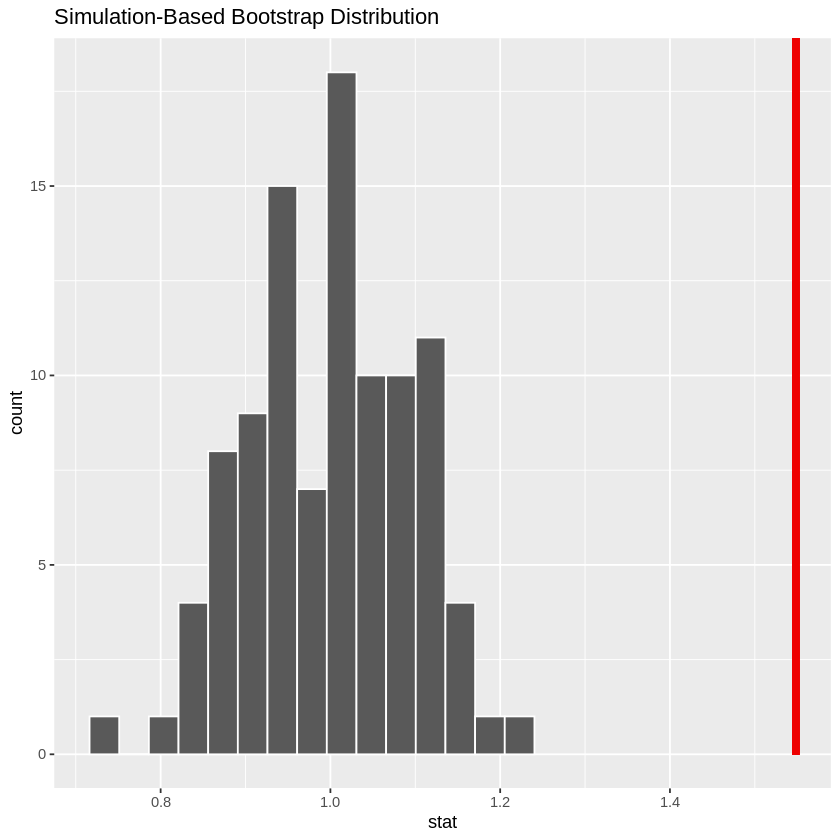

In [23]:
boot_dist_bye <- bootstrap_new %>%
                ggplot() +
                geom_histogram(aes(x = difference), binwidth = 5)
bye_bye <- mean(bootstrap_new$ratio) - 1
bootstrap_new <- bootstrap_new %>%
                mutate(stat = ratio - bye_bye)
boot_dist <- bootstrap_new %>%
                ggplot() +
                geom_histogram(aes(x = ratio), binwidth = 0.05)
                #shade_p_value(obs_stat = obs_test_ratio, direction = "greater")
boot_dist2 <- bootstrap_new %>%
                visualize() +
                shade_p_value(obs_stat = obs_test_ratio, direction = "greater")
boot_dist2
get_p_value(bootstrap_new, obs_stat = obs_test_ratio, direction = "greater")

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


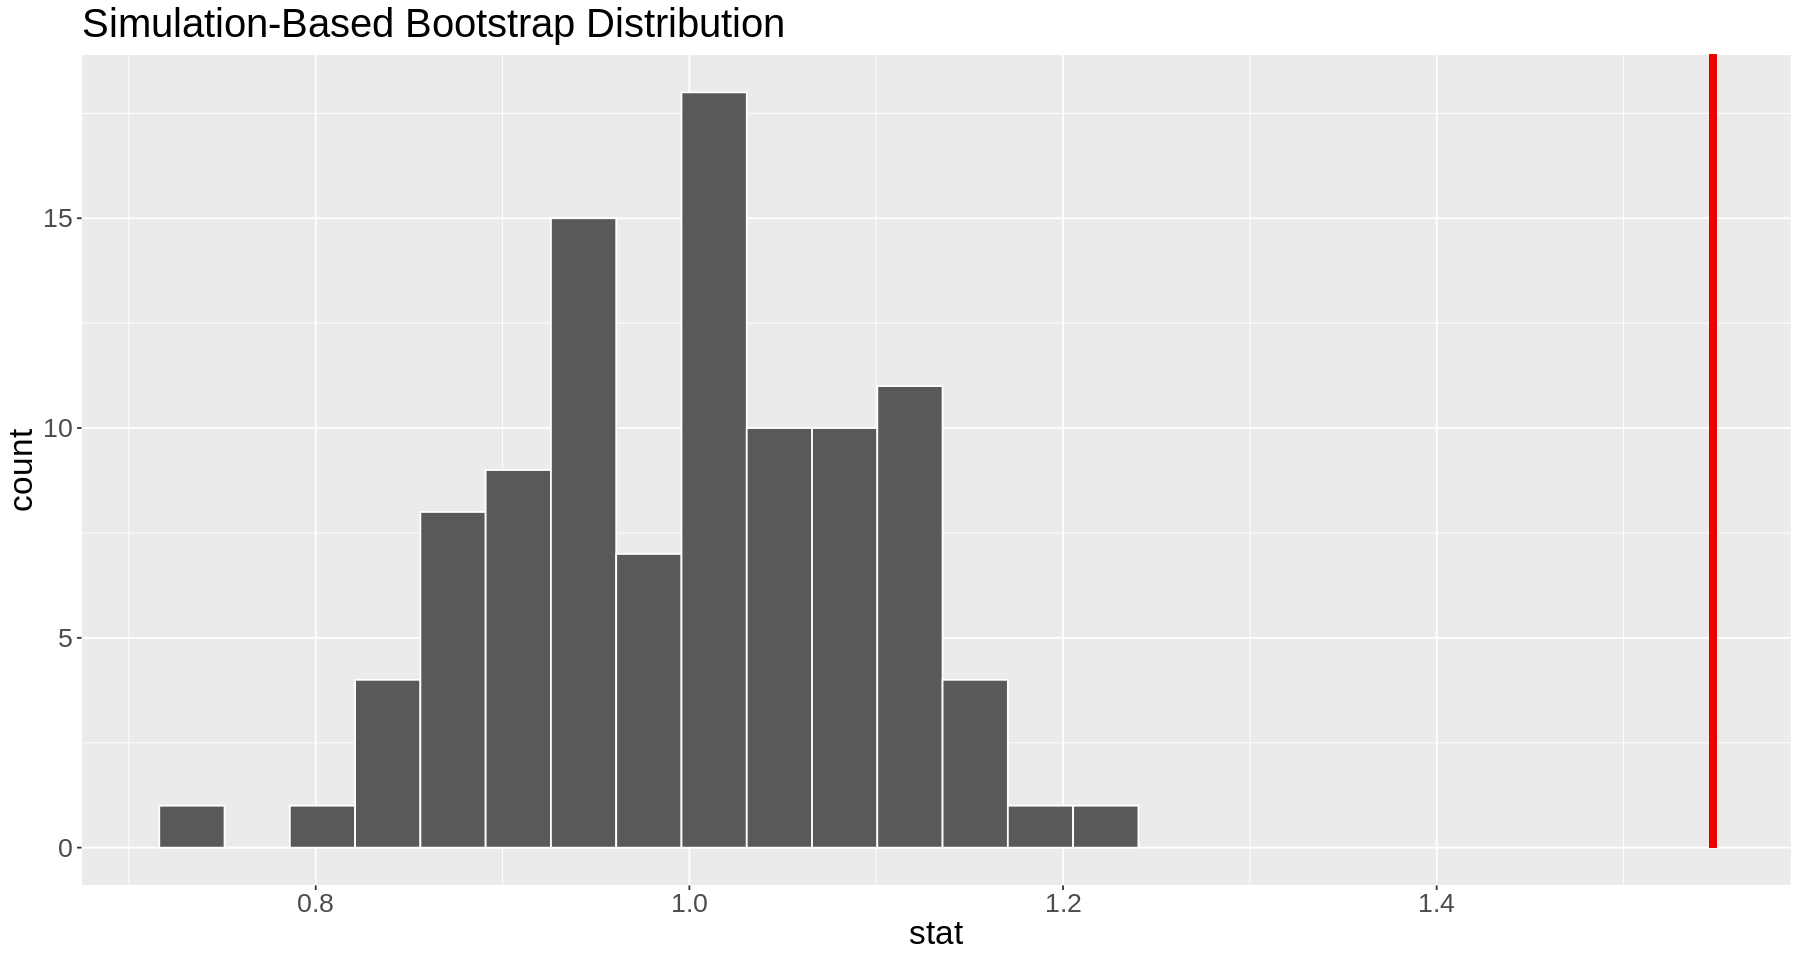

In [34]:
##P-value and confidence intervals:
# Compute p value
p_value_bike = get_p_value(bootstrap_new, obs_stat = obs_test_ratio, direction = "greater")

p_value_bike

# Visualize the bootstrap sampling distribution of difference of means of duration with shaded p-value 
options(repr.plot.width = 15, repr.plot.height = 8)
bike_result_plot <- bootstrap_new %>%
                    visualize() + 
                    shade_p_value(obs_stat = obs_test_ratio, direction = "greater")+
                    theme(text = element_text(size = 20))
bike_result_plot


In [29]:
# Compute the corresponding 95% confidence interval 
ci_0.95 <- bootstrap_new %>%
                    get_confidence_interval(level = 0.95)
ci_0.95

lower_ci,upper_ci
<dbl>,<dbl>
0.8417813,1.152809


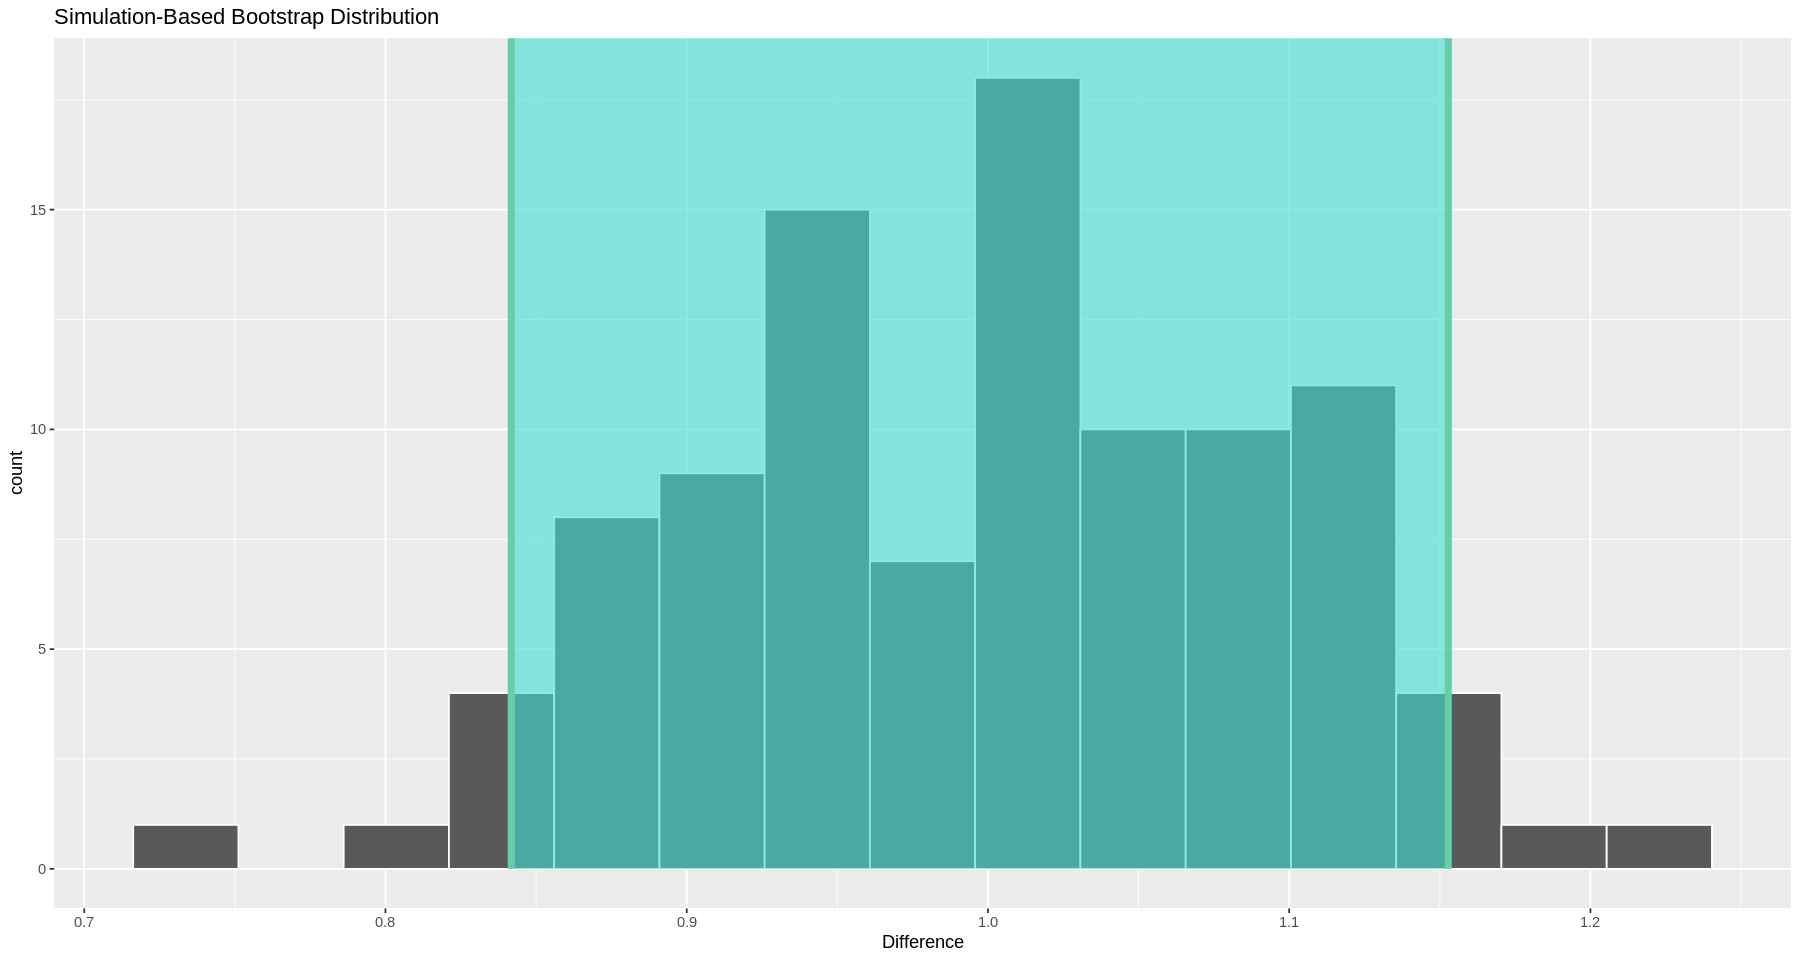

In [33]:
# Visualize bootstrap sampling distribution of ratio with shaded 95% confidence interval
options(repr.plot.width = 15, repr.plot.height = 8)
shaded_ci <- bootstrap_new %>%
                    visualize(bins = 15)+
                    shade_confidence_interval(endpoints = ci_0.95)+
                    labs(x = "Difference")
shaded_ci

We are 95% confident that this interval contains the 

For this dataset study, we believe bootstrapping are more appropriate than asymptotics. In this dataset, the "average difference gap" between time can be quite large.

## References
APA or MLA might work better
